In [5]:
import os
import tensorflow as tf
from tensorflow import keras
print(tf.version.VERSION)

2.2.0


In [2]:
#import pandas_datareader as pdr
import matplotlib.pyplot as plt
import pandas as pd
import datetime 

#from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (14, 9)   

Populating the interactive namespace from numpy and matplotlib


In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from datetime import datetime



In [4]:
data=pd.read_csv('EURUSD60.csv')
data.head()


,Date,Time,Open,High,Low,Close,Volume
0,1999.01.04,10:00,1.1801,1.1819,1.1769,1.1789,388
1,1999.01.04,11:00,1.1795,1.1819,1.1780,1.1791,490
2,1999.01.04,12:00,1.1791,1.1803,1.1788,1.1798,278
3,1999.01.04,13:00,1.1797,1.1804,1.1781,1.1782,364
4,1999.01.04,14:00,1.1780,1.1820,1.1775,1.1802,482


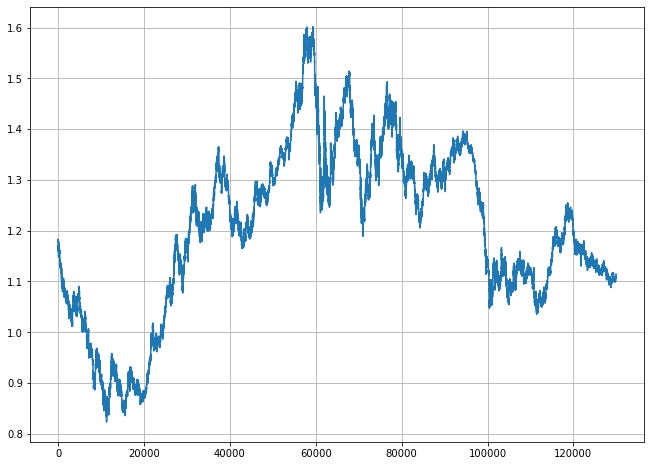

In [6]:
f, ax = plt.subplots(figsize=(11,8))

data['Close'].plot(grid = True)

In [7]:
# Fast moving window rolling mean
data['fast'] = data['Close'].rolling(window=2).mean()
# Short moving window rolling mean
data['slow'] = data['Close'].rolling(window=8).mean()

In [8]:
data=data.iloc[8:,:]
data.head()


,Date,Time,Open,High,Low,Close,Volume,fast,slow
8,1999.01.04,18:00,1.1809,1.1862,1.1806,1.1823,190,1.18170,1.180112
9,1999.01.04,19:00,1.1821,1.1836,1.1800,1.1822,280,1.18225,1.180500
10,1999.01.04,20:00,1.1821,1.1842,1.1811,1.1822,132,1.18220,1.180800
11,1999.01.04,21:00,1.1822,1.1830,1.1821,1.1829,68,1.18255,1.181387
12,1999.01.04,22:00,1.1826,1.1835,1.1826,1.1831,49,1.18300,1.181750


In [11]:
print(len(data.slow.shift(1)),len( data.slow))
data.tail()

129927 129927


,Date,Time,Open,High,Low,Close,Volume,fast,slow
129930,2019.12.12,17:00,1.11249,1.11362,1.11113,1.11171,5186,1.112095,1.112951
129931,2019.12.12,18:00,1.11171,1.11214,1.11104,1.11142,3525,1.111565,1.112684
129932,2019.12.12,19:00,1.11143,1.11171,1.11080,1.11101,2331,1.111215,1.112466
129933,2019.12.12,20:00,1.11101,1.11133,1.11029,1.11100,2431,1.111005,1.112231
129934,2019.12.12,21:00,1.11098,1.11131,1.11039,1.11113,3011,1.111065,1.111971


In [76]:
def get_up_cross(df):
    crit1 = df.fast.shift(1) < df.slow.shift(1)
    crit2 = df.fast > df.slow
    return df.fast[(crit1) & (crit2)]

def get_down_cross(df):
    crit1 = df.fast.shift(1) > df.slow.shift(1)
    crit2 = df.fast < df.slow
    return df.fast[(crit1) & (crit2)]



In [77]:
up = get_up_cross(data)
down = get_down_cross(data)


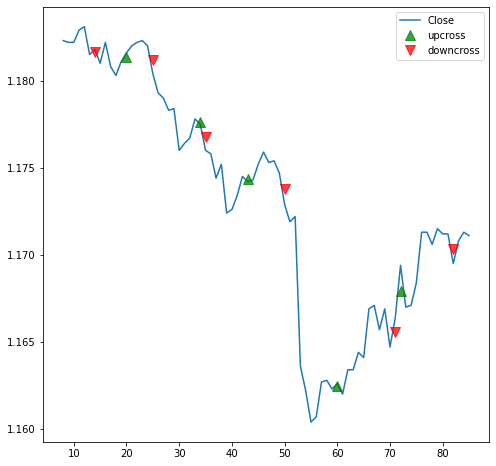

In [78]:
f, ax = plt.subplots(figsize=(8,8))

# Plot the adj usted closing price, the short and long windows of rolling means
data.loc[:85,['Close']].plot(ax=ax, grid=True)

up[:5].plot(ax=ax,ls='',marker='^', markersize=10,
                     alpha=0.75, label='upcross', color='g')

down[:6].plot(ax=ax,ls='',marker='v', markersize=10, 
                       alpha=0.75, label='downcross', color='r')


ax.legend()

In [79]:
display(len(up.index), len(down.index))

10536

10537

In [80]:
# Creates a labebls
side_up = pd.Series(1, index=up.index).dropna()   #buy
side_down = pd.Series(-1, index=down.index).dropna() #sell
side_hold=pd.Series(0, index=data.index).dropna()
side_hold.drop(index=up.index,inplace=True)
side_hold.drop(index=down.index,inplace=True)

side = pd.concat([side_up,side_down,side_hold]).sort_index()
display(side[:20], side.shape)

8     0
9     0
10    0
11    0
12    0
13    0
14   -1
15    0
16    0
17    0
18    0
19    0
20    1
21    0
22    0
23    0
24    0
25   -1
26    0
27    0
dtype: int64

(129927,)

In [81]:
side=pd.DataFrame(data=side,columns=['label'])
type(side)
side.head()

,label
8,0
9,0
10,0
11,0
12,0


In [82]:
 n_data=pd.merge(data, side, left_index=True, right_index=True)
n_data.head()

,Date,Time,Open,High,Low,Close,Volume,fast,slow,label
8,1999.01.04,18:00,1.1809,1.1862,1.1806,1.1823,190,1.18170,1.180112,0
9,1999.01.04,19:00,1.1821,1.1836,1.1800,1.1822,280,1.18225,1.180500,0
10,1999.01.04,20:00,1.1821,1.1842,1.1811,1.1822,132,1.18220,1.180800,0
11,1999.01.04,21:00,1.1822,1.1830,1.1821,1.1829,68,1.18255,1.181387,0
12,1999.01.04,22:00,1.1826,1.1835,1.1826,1.1831,49,1.18300,1.181750,0


In [83]:
side['label'].value_counts()

 0    108854
-1     10537
 1     10536
Name: label, dtype: int64

In [86]:
new_data=n_data.loc[:,['Open','High','Low','Close','label']]
new_data.head()


,Open,High,Low,Close,label
8,1.1809,1.1862,1.1806,1.1823,0
9,1.1821,1.1836,1.1800,1.1822,0
10,1.1821,1.1842,1.1811,1.1822,0
11,1.1822,1.1830,1.1821,1.1829,0
12,1.1826,1.1835,1.1826,1.1831,0


In [87]:
X=new_data.iloc[:,:-1].values
y=new_data.iloc[:,-1].values

In [90]:
from sklearn.model_selection import train_test_split
train_X,test_X,train_y,test_y=train_test_split(X,y,test_size=0.2)

In [92]:
from sklearn.preprocessing import OneHotEncoder
onehot=OneHotEncoder()
train_y=onehot.fit_transform(train_y.reshape(-1,1)).toarray()
test_y=onehot.fit_transform(test_y.reshape(-1,1)).toarray()

In [93]:
n_features=4
n_mins=1

In [94]:
train_X=train_X.reshape(train_X.shape[0],n_mins,n_features)
test_X=test_X.reshape(test_X.shape[0],n_mins,n_features)
print(train_X.shape,test_X.shape)

(103941, 1, 4) (25986, 1, 4)


In [ ]:
# define model
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(Dense(50,activation='relu')) #dense -> fully connected layer
model.add(Dropout(0.6))
model.add(Dense(20,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10,activation='relu')) 
model.add(Dropout(0.3))
model.add(Dense(1,activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()	


In [100]:
# Define a simple sequential model
def create_model():
    model = tf.keras.models.Sequential([
    keras.layers.LSTM(200, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(3,activation='softmax')
  ])

    model.compile(optimizer='adam',
                loss=tf.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    return model

# Create a basic model instance
model = create_model()

# Display the model's architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200)               164000    
_________________________________________________________________
dense_2 (Dense)              (None, 50)                10050     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 153       
Total params: 174,203
Trainable params: 174,203
Non-trainable params: 0
_________________________________________________________________


In [101]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Train the model with the new callback
history=model.fit(train_X, 
          train_y,  
          epochs=50,
          validation_split=0.2,
          callbacks=[cp_callback])  # Pass callback to training

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

Epoch 1/50
2599/2599 [==============================] - ETA: 0s - loss: 0.7190 - accuracy: 0.8372
Epoch 00001: saving model to training_1/cp.ckpt
2599/2599 [==============================] - 45s 17ms/step - loss: 0.7190 - accuracy: 0.8372 - val_loss: 0.7148 - val_accuracy: 0.8367
Epoch 2/50
2599/2599 [==============================] - ETA: 0s - loss: 0.7141 - accuracy: 0.8373
Epoch 00002: saving model to training_1/cp.ckpt
2599/2599 [==============================] - 45s 17ms/step - loss: 0.7141 - accuracy: 0.8373 - val_loss: 0.7148 - val_accuracy: 0.8367
Epoch 3/50
2597/2599 [============================>.] - ETA: 0s - loss: 0.7141 - accuracy: 0.8373
Epoch 00003: saving model to training_1/cp.ckpt
2599/2599 [==============================] - 49s 19ms/step - loss: 0.7141 - accuracy: 0.8373 - val_loss: 0.7148 - val_accuracy: 0.8367
Epoch 4/50
2598/2599 [============================>.] - ETA: 0s - loss: 0.7141 - accuracy: 0.8373
Epoch 00004: saving model to training_1/cp.ckpt
2599/2599 [

In [103]:

accr = model.evaluate(test_X,test_y)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.1f} %'.format(accr[0],round(accr[1]*100,1)))

813/813 [==============================] - 6s 7ms/step - loss: 0.7111 - accuracy: 0.8403
Test set
  Loss: 0.711
  Accuracy: 84.0 %


In [104]:

accr = model.evaluate(test_X,test_y)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.1f} %'.format(accr[0],round(accr[1]*100,1)))

813/813 [==============================] - 6s 7ms/step - loss: 0.7111 - accuracy: 0.8403
Test set
  Loss: 0.711
  Accuracy: 84.0 %


In [106]:
prediction=model.predict(test_X)
prediction

array([[1.4245264e-35, 1.0000000e+00, 6.6459374e-34],
       [3.7394241e-20, 1.0000000e+00, 3.1049036e-19],
       [6.9696547e-27, 1.0000000e+00, 1.2256162e-25],
       ...,
       [1.3641445e-30, 1.0000000e+00, 3.6347296e-29],
       [9.2219238e-22, 1.0000000e+00, 9.1580259e-21],
       [1.3872064e-25, 1.0000000e+00, 2.1097541e-24]], dtype=float32)

In [107]:
predict_class = np.argmax(prediction , axis=1)
predict_class = predict_class.tolist()


In [117]:
from collections import Counter
Counter(predict_class)

Counter({1: 25986})